# LDA for search term exploration

Don't know if this is useful, going to try anyway. This one runs a bunch of LDA models with different numbers of topics using the sklearn implementation. Models are then pickled and stored to be reloaded. Perplexity is plotted to help in picking the right model. The top words of this model can then be printed in a LaTeX table which requires minimal work.

In [1]:
%matplotlib inline

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain
from sqlite_db import thesisDB
from stop_words import get_stop_words
import matplotlib.ticker
import tabulate
import pickle
import seaborn as sns
import numpy as np
import math
from random import shuffle
import json

pickle_file = ['D:/thesis/nl/data_lda/models/lda','.p']
perplexity_fig = 'D:/thesis/nl/data_lda/models/perplexity.pdf'
db_file = 'D:/thesis/nl/data_lda/data.db'
db = thesisDB(db_file)

def termScores(word_array):
    K = word_array.shape[0]
    denominator = word_array.prod()**(1/K)
    return np.array([x*math.log(x/denominator) for x in word_array])

In [2]:
#Get lemmatized corpus from the DB
cursor = db.getTokens(returnColumns=['lemma','pos','docid','paragraph_no'])

corpus = []
currentDoc = 1
currentParagraph = 1
doc = []
paragraph = []

for lemma, pos, docid, paragraph_no in cursor:
    if docid != currentDoc and doc: #We hit a new document!
        doc.append(paragraph)
        corpus.append((currentDoc,doc))
        paragraph = []
        doc = []
        currentDoc = docid
        currentParagraph = paragraph_no
    elif paragraph_no != currentParagraph and paragraph: #New paragraph!
        doc.append(paragraph)
        paragraph = []
        currentParagraph = paragraph_no
    if pos != 'LET':
        paragraph.append((lemma,pos))

doc.append(paragraph)
corpus.append((currentDoc,doc))

corpus_flat = [list(chain.from_iterable(doc[1])) for doc in corpus]
corpus_flat = [[lemma for lemma,pos in doc] for doc in corpus_flat ]

#Construct sparse matrix for BOW
vectorizer = CountVectorizer(min_df = .005, max_df = .95, stop_words = get_stop_words('nl'))
bow = vectorizer.fit_transform([' '.join(document) for document in corpus_flat])
features = vectorizer.get_feature_names()

#Split train-test, stratified by 1-200, 201-400, 401-600 etc.
#train_docs = []
#samples = [[(i,True) if i < j*200+150 else (i,False) for i in range(j*200,(j+1)*200)] for j in range(9)]
#samples.append([(i,True) if i < 1950 else (i,False) for i in range(1800,1991)])
#for i in range(10): #Random shuffle within category
#    shuffle(samples[i])
#    train_docs += samples[i]

train_docs = json.load(open('D:/thesis/nl/data_lda/models/train_test_split.json','r'))

bow_train = bow[[i for i,b in train_docs if b],:]
bow_test = bow[[i for i,b in train_docs if not b],:]

In [65]:
json.dump(train_docs,open('D:/thesis/nl/data_lda/models/train_test_split.json','w+'))

In [68]:
##Train LDA models --> DO NOT RUN RANDOMLY, TAKES TIME.
models = dict()

for ntopics in range(2,40):
    
    lda = LatentDirichletAllocation(n_components = ntopics, max_iter = 100, learning_method = 'online')
    lda = lda.fit(bow_train)
    models[ntopics] = lda

    pickle.dump(lda,open(str(ntopics).join(pickle_file),'wb'))

perplexities = [model.perplexity(bow_test) for k,model in models.items()]

In [3]:
##Alternative: Reload models to continue working
models = dict()

for ntopics in range(2,40):
    models[ntopics] = pickle.load(open(str(ntopics).join(pickle_file),'rb'))

perplexities = [model.perplexity(bow_test) for k,model in models.items()]

C:\Users\Max\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


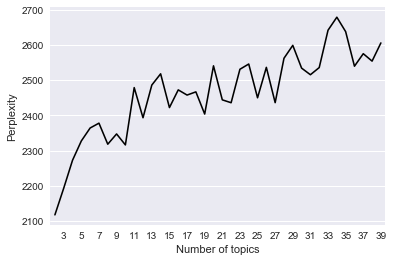

In [9]:
#plot the perplexities to support model choice
sns.set()
ax = sns.pointplot(x = np.array(list(models.keys())), y = perplexities, markers = '', color = 'black', scale = .5)
ax.set(xlabel = 'Number of topics',ylabel = 'Perplexity')
labels = ax.get_xticklabels() # get x labels
for i,l in enumerate(labels):
    if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels)
fig = ax.get_figure()
fig.savefig(perplexity_fig)

In [16]:
#Choose model and load the associated words. Per topic a list of tuples (word,parameter), sorted by parameter (DESC)
ntopics = 4
lda = models[ntopics]

term_scores = True

if term_scores:
    scores = np.array([termScores(word) for word in lda.components_.T]).T
else:
    scores = lda.components_

lda_params = {i+1:[(feature,parameter) for feature,parameter in zip(features,scores[i])] for i in range(ntopics)}
lda_params = {k:sorted(v,key=lambda x: x[1],reverse = True) for k,v in lda_params.items()}
del lda

In [111]:
#LaTeX table for top words, previous cell must be run for this, so ntopics is presumed set

#Modify tabulate package rule to remove backslashes, allows for printing of format \textbf{}:
#del tabulate.LATEX_ESCAPE_RULES['\\'], tabulate.LATEX_ESCAPE_RULES['{'], tabulate.LATEX_ESCAPE_RULES['}']

ntopwords = 30
topwords = []
for i in range(1,ntopics+1):
    topwords.append([word for (word,parameter) in lda_params[i][0:15]])
    topwords.append([word for (word,parameter) in lda_params[i][16:30]])
topwords = list(map(list, zip(*topwords)))
headings = [['\\textbf{Topic '+str(i)+'}' for i in range(1,ntopics+1)]]
print(tabulate.tabulate(headings+topwords, tablefmt = 'latex_booktabs'))
#modifications to do in LaTeX file:
# - Add rule below table headings
# - Add \multicolumn for Note.

\begin{tabular}{llllll}
\toprule
 \textbf{Topic 1} & \textbf{Topic 2} & \textbf{Topic 3} &             &            &              \\
 miljard          & ecb              & turkije          & sanctie     & nederland  & gaan         \\
 euro             & fonds            & vluchteling      & europees    & grondwet   & markt        \\
 bank             & lening           & navo             & oostenrijk  & nederlands & commissie    \\
 griekenland      & staatsschuld     & turks            & asielzoeker & europees   & europa       \\
 euroland         & grieks           & rusland          & zullen      & mens       & wel          \\
 imf              & iers             & eu               & betrekking  & we         & bolkestein   \\
 ierland          & procent          & politiek         & diplomaat   & bedrijf    & kabinet      \\
 financieel       & cameron          & europa           & regering    & oekraïne   & groot        \\
 emu              & belegger         & buitenlands      & 

In [20]:
lda_params[4][:30]

[('minister', 1720.8511990026764),
 ('oostenrijk', 1613.5156653618833),
 ('haider', 1274.5604870196507),
 ('oostenrijks', 1267.5672846520567),
 ('navo', 1205.1082420534692),
 ('frankrijk', 1166.2234886118449),
 ('frans', 1158.2382555700542),
 ('buitenlands', 1141.2369032141612),
 ('santer', 1138.0584478369735),
 ('politiek', 1029.6246891287797),
 ('commissie', 962.45367819394835),
 ('prodi', 927.33981474355426),
 ('parlement', 926.22841333011411),
 ('europees', 866.01489562094866),
 ('fpo', 824.54330526097408),
 ('betrekking', 754.96610550461901),
 ('unie', 735.57147282684662),
 ('delors', 676.79867626352154),
 ('maastricht', 671.72195148479079),
 ('kok', 623.99488022904802),
 ('aartsen', 621.86738042957813),
 ('mierlo', 615.52942745431938),
 ('sanctie', 566.03000323658819),
 ('gemeenschappelijk', 558.61275808323796),
 ('defensie', 543.96992392867435),
 ('rusland', 539.32782882710967),
 ('gisteren', 507.6348060717238),
 ('chirac', 505.12474026072209),
 ('zaak', 495.93003315174877),
 ('

In [10]:
json.load(open('D:/thesis/nl/data_lda/models/train_test_split.json','r'))

[[57, True],
 [76, True],
 [130, True],
 [128, True],
 [183, False],
 [7, True],
 [148, True],
 [197, False],
 [14, True],
 [23, True],
 [101, True],
 [139, True],
 [97, True],
 [174, False],
 [111, True],
 [113, True],
 [92, True],
 [172, False],
 [100, True],
 [63, True],
 [77, True],
 [44, True],
 [169, False],
 [166, False],
 [105, True],
 [88, True],
 [71, True],
 [26, True],
 [95, True],
 [59, True],
 [9, True],
 [87, True],
 [135, True],
 [46, True],
 [102, True],
 [90, True],
 [62, True],
 [154, False],
 [149, True],
 [106, True],
 [157, False],
 [8, True],
 [37, True],
 [110, True],
 [99, True],
 [31, True],
 [0, True],
 [98, True],
 [109, True],
 [80, True],
 [123, True],
 [16, True],
 [79, True],
 [189, False],
 [186, False],
 [49, True],
 [94, True],
 [155, False],
 [178, False],
 [39, True],
 [108, True],
 [129, True],
 [52, True],
 [89, True],
 [45, True],
 [51, True],
 [137, True],
 [141, True],
 [188, False],
 [162, False],
 [20, True],
 [58, True],
 [47, True],
 [33, T